# Relationship between OLS and DML
Julian Hsu
9-aug-2023

We examine the relationship between OLS and DML, where we see how DML performance varies over whether we use OLS for its internal components or not, and how performance varies over splitting with OLS as the nuisance function.

[Main result here](#main_result). I do not show this graphically because the OLS and DML with OLS estimate are **perfectly correlated**.


In [1]:
import numpy as np
import pandas as pd

%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import r2_score


In [2]:
import stnomics as st

Write a DGP function with a treatment indicator and confounding features.

The treatment effect will be a standard deviation of the potential control outcome.

In [59]:
def dgp(N=1000,K=3,ate_sd = 0.1
       , allow_log=True):
    '''
    N  number of rows
    K  number of confounding variables
    ate_sd  the impact in standard deviations of the outcome
    allow_log  all logs of the confounders to enter into outcome and treatment
    '''
    
    df_out = pd.DataFrame()
    ## Create covariates
    for k in range(K):
        df_out['x{0:1.0f}'.format(k)] = np.random.normal(0,0.50,N)
    ## Alternate between positive and negative coefficient estimates
    ## for the outcome and treatment
    y_array = np.random.uniform(1,2,K) * [1-2*(i%2) for i in range(K)]
    t_array = np.random.uniform(1,2,K) * [1-2*(i%2) for i in range(K)]
    
    if allow_log==True:
        y_array_log = np.random.uniform(1.5,3,K) * [-1+2*(i%2) for i in range(K)]
        t_array_log = np.random.uniform(1.5,3,K) * [-1+2*(i%2) for i in range(K)]
    
    ## Create treatment indicator
    w_latent = np.dot(df_out[[e for e in df_out.columns if 'x' in e]], t_array)
    if allow_log==True:
        w_latent += np.dot(np.log(1+np.abs(df_out[[e for e in df_out.columns if 'x' in e]])), t_array_log)
        
    df_out['w'] = ( np.exp(w_latent) / (3+ np.exp(w_latent)) > np.random.uniform(0,1,N) ).astype(float)
    
    ## Create outcome 
    df_out['y'] = np.dot(df_out[[e for e in df_out.columns if 'x' in e]], y_array)
    if allow_log==True:
        df_out['y'] += np.dot(np.log(3+np.abs(df_out[[e for e in df_out.columns if 'x' in e]])), y_array_log)
        
    ate_to_use = ate_sd * df_out['y'].std()
    
    df_out['y'] += df_out['w']*ate_to_use
    df_out['y'] += np.random.normal(0,1, N)
    
    df_out['gt'] = ate_to_use
    
    return df_out

In [60]:
## Estimate the treatment effect without sample-splitting
def dml_estimate(data=None,X_list=None
                , model_y=Ridge(alpha=1, fit_intercept=True)
                , model_t=LogisticRegression(penalty='l2', C=1, fit_intercept=True)
                , outcome_residualization=False
                , treatment_residualization=False):
    condition=((outcome_residualization==True ) | (treatment_residualization==True))
    assert condition ==True, 'Outcome or Treatment residualization must be True'
                
    if treatment_residualization==False:
        W = np.array(data['w']).reshape(-1, 1)
    else:
        ml_t_model = model_t.fit(X=data[X_list], y = data['w'] )        
        try:
            W = np.array(data['w'] - ml_t_model.predict_proba(data[X_list])[:,1]).reshape(-1,1)
        except:
            W = np.array(data['w'] - ml_t_model.predict(data[X_list])).reshape(-1,1)
        
    if outcome_residualization==False:
        YM = data['y'].values
    else:        
        ml_model = model_y.fit(X=data[X_list], y = data['y'] )    
        YM = data['y'] - ml_model.predict(data[X_list])

    ols_model_r = LinearRegression(fit_intercept=True).fit(X=W, y = YM)
        
    return ols_model_r.coef_[-1]

## Simulations of estimating impact of linear and non-linear data
We look at the bias of OLS, DML with OLS, and DML with non-OLS nuisance functions, and how this bias varies over whether the data is truly linear.

In [73]:
sim_times = 30

In [83]:
i=0
df_results= pd.DataFrame()

for s in range(sim_times):
    ## Linear Data
    df = dgp(allow_log=False)

    ## ols only
    ols_result = LinearRegression(fit_intercept=True).fit(X=df[['w','x0','x1','x2']], y = df['y']).coef_[0]

    ## dml with OLS components
    dml_ols = dml_estimate(data=df, X_list=['x0','x1','x2'], model_y=LinearRegression(), model_t=LinearRegression()
                    , outcome_residualization=True, treatment_residualization=True)

    ## dml with ridge and logistic regression components
    dml_no_ols = dml_estimate(data=df, X_list=['x0','x1','x2'], model_y=RandomForestRegressor(n_jobs=-1,n_estimators=20), model_t=RandomForestClassifier(n_jobs=-1, n_estimators=20)
                    , outcome_residualization=True, treatment_residualization=True)

    df_results = pd.concat([df_results, pd.DataFrame(index=[s], data={'gt':df['gt'][0],
                                                                      'ols':ols_result,
                                                          'dml_ols':dml_ols,
                                                          'dml_no_ols':dml_no_ols,
                                                          'data':'linear'}) ] )

    ## Linear Data
    df = dgp(allow_log=True)

    ## ols only
    ols_result = LinearRegression(fit_intercept=True).fit(X=df[['w','x0','x1','x2']], y = df['y']).coef_[0]

    ## dml with OLS components
    dml_ols = dml_estimate(data=df, X_list=['x0','x1','x2'], model_y=LinearRegression(), model_t=LinearRegression()
                    , outcome_residualization=True, treatment_residualization=True)

    ## dml with ridge and logistic regression components
    dml_no_ols = dml_estimate(data=df, X_list=['x0','x1','x2'], model_y=RandomForestRegressor(n_jobs=-1,n_estimators=20), model_t=RandomForestClassifier(n_jobs=-1, n_estimators=20)
                    , outcome_residualization=True, treatment_residualization=True)

    df_results = pd.concat([df_results, pd.DataFrame(index=[s], data={'gt':df['gt'][0],
                                                                      'ols':ols_result,
                                                          'dml_ols':dml_ols,
                                                          'dml_no_ols':dml_no_ols,
                                                          'data':'nonlinear'}) ] )


In [85]:
for a in ['ols','dml_ols','dml_no_ols']:
    df_results[a+'_diff'] = df_results[a]-df_results['gt']

### Main result here!
<a id='main_result'></a>

Graphical examples of performance using non-OLS ML models, over linear and non-linear models follow.

In [97]:
display( df_results.corr()[['ols','dml_ols']].iloc[[1,2]] )

,ols,dml_ols
ols,1.0,1.0
dml_ols,1.0,1.0


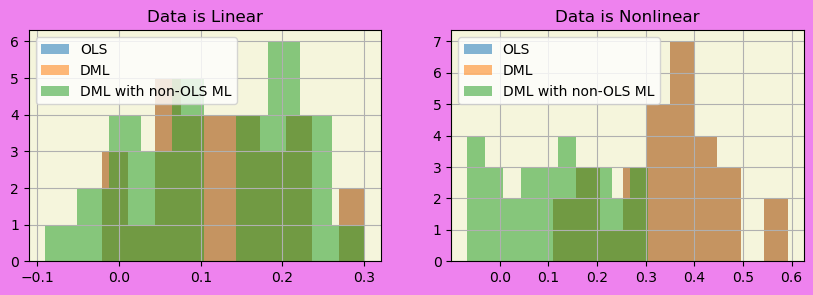

In [91]:
fig,ax= plt.subplots(ncols=2,nrows=1,figsize=(10,3)) 

for e in enumerate(['linear','nonlinear']):
    ax[e[0]].set_facecolor('beige')
    for a in zip(['ols','dml_ols','dml_no_ols'], ['OLS','DML','DML with non-OLS ML']):
        ax[e[0]].hist(df_results.loc[df_results['data']==e[1]][a[0]] ,
                      alpha=0.55,
                     label=a[1])
    
    ax[e[0]].legend()
    ax[e[0]].set_title('Data is {0}'.format(e[1].title() ))
    ax[e[0]].grid()
    
fig.set_facecolor('violet')
plt.show()


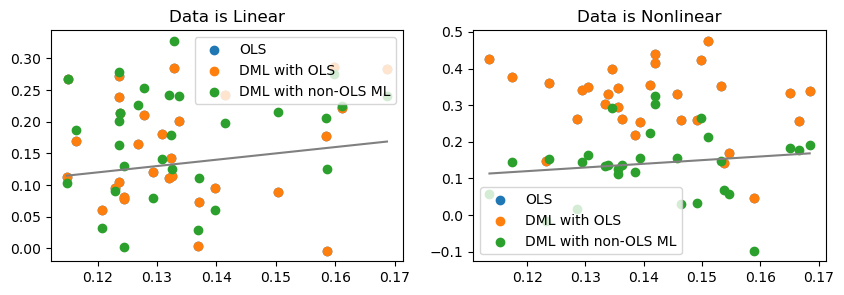

In [78]:
fig,ax= plt.subplots(ncols=2,nrows=1,figsize=(10,3)) 

for e in enumerate(['linear','nonlinear']):
    ax[e[0]].scatter(df_results.loc[df_results['data']==e[1]]['gt']
                    ,df_results.loc[df_results['data']==e[1]]['ols']
                    , label='OLS')
    ax[e[0]].scatter(df_results.loc[df_results['data']==e[1]]['gt']
                    ,df_results.loc[df_results['data']==e[1]]['dml_ols']
                    , label='DML with OLS')
    ax[e[0]].scatter(df_results.loc[df_results['data']==e[1]]['gt']
                    ,df_results.loc[df_results['data']==e[1]]['dml_no_ols']
                    , label='DML with non-OLS ML')
    ax[e[0]].plot(df_results.loc[df_results['data']==e[1]]['gt'].sort_values()
                    ,df_results.loc[df_results['data']==e[1]]['gt'].sort_values()
                     ,color='grey')
    
    ax[e[0]].legend()
    ax[e[0]].set_title('Data is {0}'.format(e[1].title() ))